In [23]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
from collections import Counter
import os
import time
import psutil
from tqdm.notebook import tqdm
import random
import os

from augmentations_basics.datasets import CustomImageDataset
from augmentations_basics.extra_augs import AddGaussianNoise, CutOut

device = torch.device('cuda')

DATA_ROOT_TRAIN = 'data/train'
DATA_ROOT_VAL = 'data/val'
SAVE_DIR = 'results'
os.makedirs(SAVE_DIR, exist_ok=True)

In [24]:
def show_images(images, labels=None, nrow=8, title=None, size=128):
    """Визуализирует батч изображений."""
    images = images[:nrow]

    # Увеличиваем изображения до 128x128 для лучшей видимости
    resize_transform = transforms.Resize((size, size), antialias=True)
    images_resized = [resize_transform(img) for img in images]

    # Создаем сетку изображений
    fig, axes = plt.subplots(1, nrow, figsize=(nrow * 2, 2))
    if nrow == 1:
        axes = [axes]

    for i, img in enumerate(images_resized):
        img_np = img.numpy().transpose(1, 2, 0)
        # Нормализуем для отображения
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
        if labels is not None:
            axes[i].set_title(f'Label: {labels[i]}')

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def show_single_augmentation(original_img, augmented_img, title="Аугментация", save_name=None):
    """Визуализирует и сохраняет оригинальное и аугментированное изображение рядом"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)
    aug_resized = resize_transform(augmented_img)

    # Оригинальное изображение
    to_tensor_transform = transforms.ToTensor()
    orig_tensor = to_tensor_transform(orig_resized)
    orig_np = orig_tensor.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    ax1.imshow(orig_np)
    ax1.set_title("Оригинал")
    ax1.axis('off')

    # Аугментированное изображение
    aug_np = aug_resized.numpy().transpose(1, 2, 0)
    aug_np = np.clip(aug_np, 0, 1)
    ax2.imshow(aug_np)
    ax2.set_title(title)
    ax2.axis('off')

    plt.tight_layout()

    if save_name:
        path = os.path.join(SAVE_DIR, save_name)
        plt.savefig(path)
        print(f"Изображение сохранено: {path}")

    plt.show()


def show_multiple_augmentations(original_img, augmented_imgs, titles, save_name=None):
    """Визуализирует и сохраняет оригинальное изображение и несколько аугментаций"""
    n_augs = len(augmented_imgs)
    fig, axes = plt.subplots(1, n_augs + 1, figsize=((n_augs + 1) * 2.5, 2.5))

    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)

    # Оригинальное изображение
    to_tensor_transform = transforms.ToTensor()
    orig_tensor = to_tensor_transform(orig_resized)
    orig_np = orig_tensor.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    axes[0].imshow(orig_np)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')

    # Аугментированные изображения
    for i, (aug_img, title) in enumerate(zip(augmented_imgs, titles)):
        aug_resized = resize_transform(aug_img)
        aug_np = aug_resized.numpy().transpose(1, 2, 0)
        aug_np = np.clip(aug_np, 0, 1)
        axes[i + 1].imshow(aug_np)
        axes[i + 1].set_title(title)
        axes[i + 1].axis('off')

    plt.tight_layout()

    if save_name:
        path = os.path.join(SAVE_DIR, save_name)
        plt.savefig(path)
        print(f"Изображение сохранено: {path}")

    plt.show()

Найдено 180 изображений в 6 классах.

аугментация класса: Гароу

Изображение сохранено: results\task1_Гароу_hflip.png


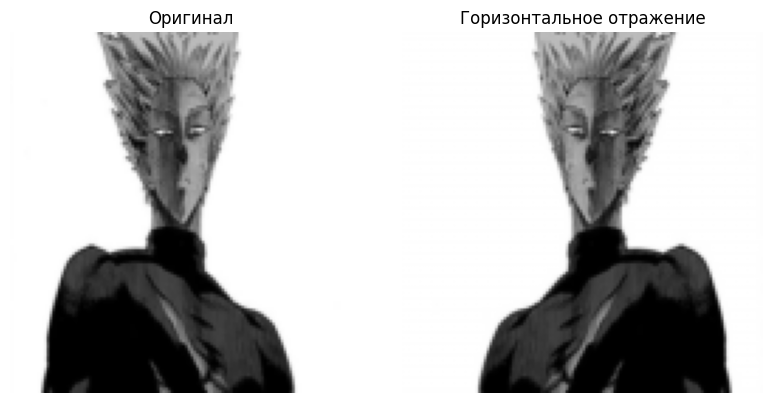

Изображение сохранено: results\task1_Гароу_crop.png


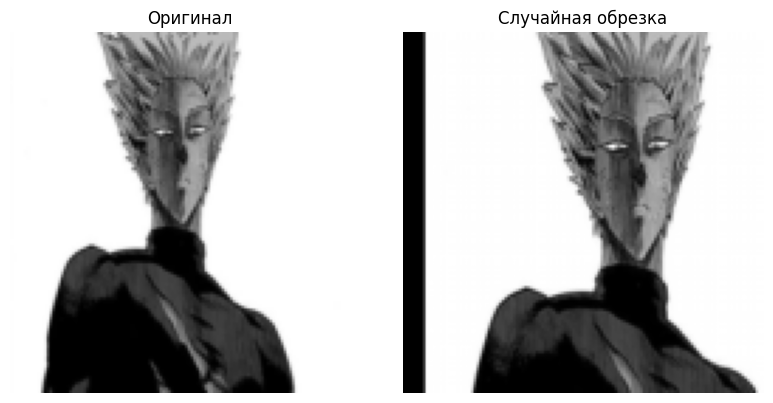

Изображение сохранено: results\task1_Гароу_jitter.png


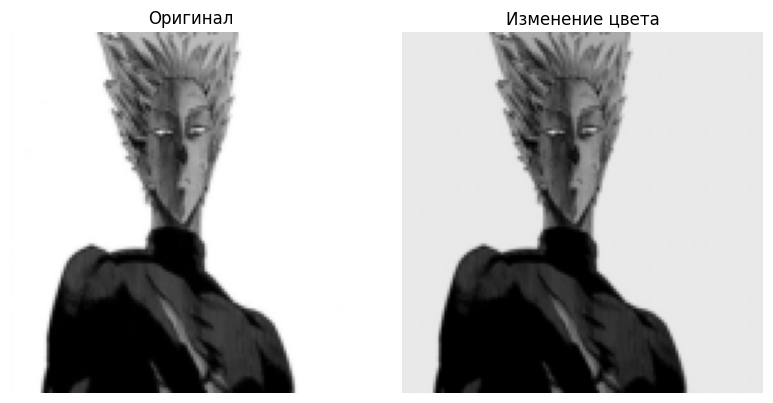

Изображение сохранено: results\task1_Гароу_rotation.png


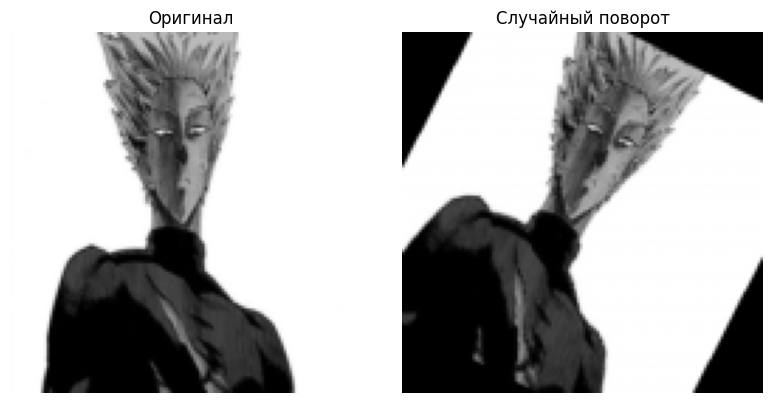

Изображение сохранено: results\task1_Гароу_grayscale.png


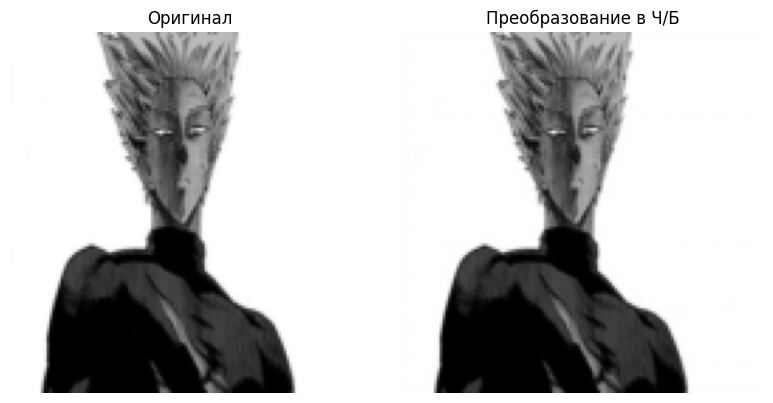

Изображение сохранено: results\task1_Гароу_combo.png


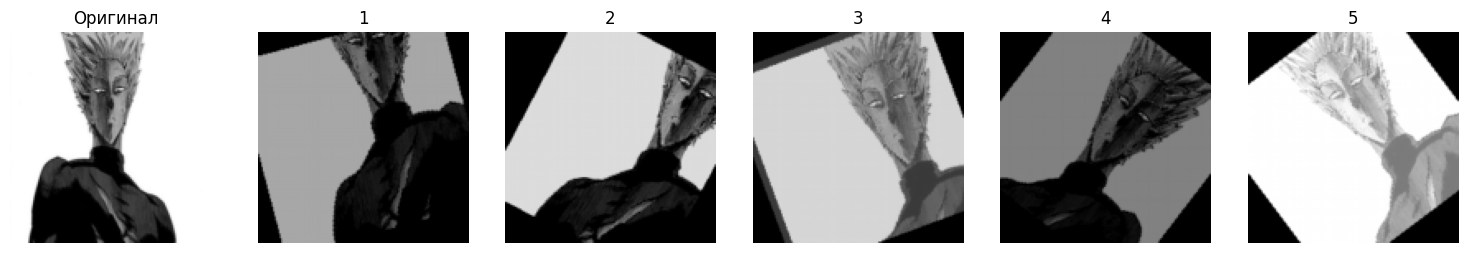


аугментация класса: Генос

Изображение сохранено: results\task1_Генос_hflip.png


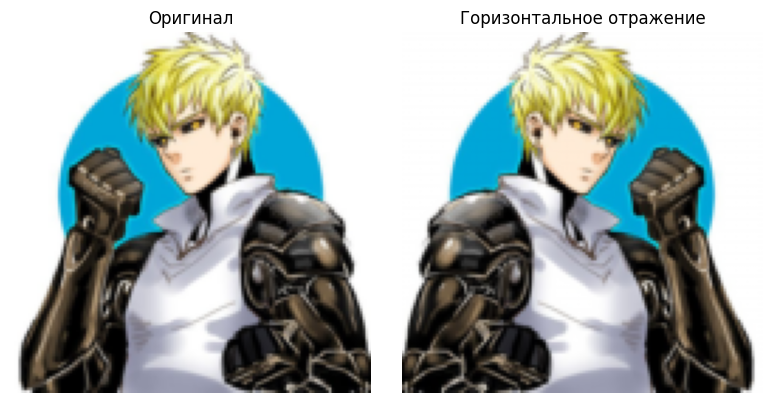

Изображение сохранено: results\task1_Генос_crop.png


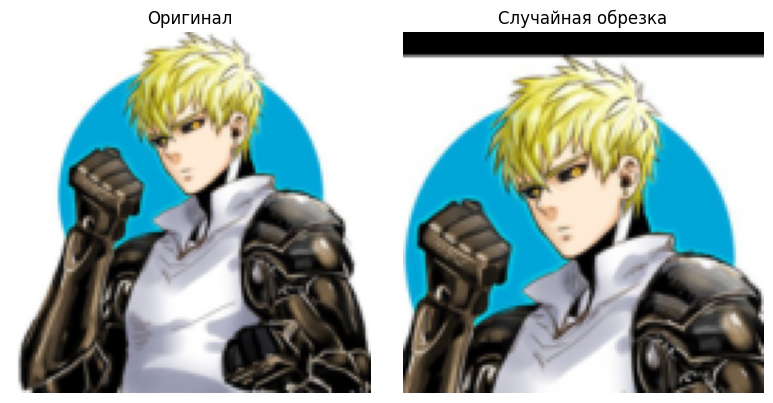

Изображение сохранено: results\task1_Генос_jitter.png


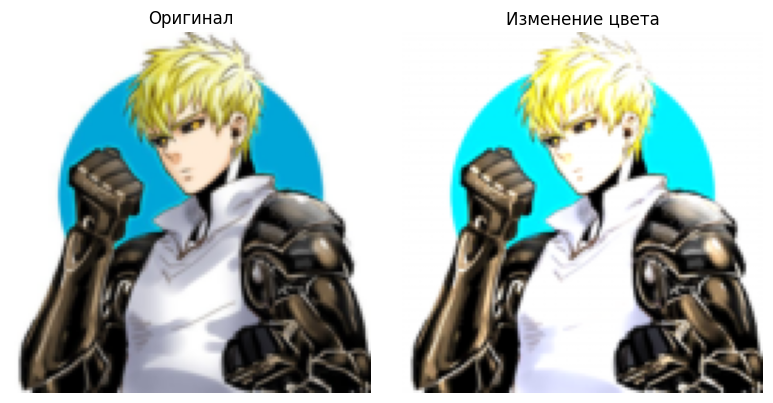

Изображение сохранено: results\task1_Генос_rotation.png


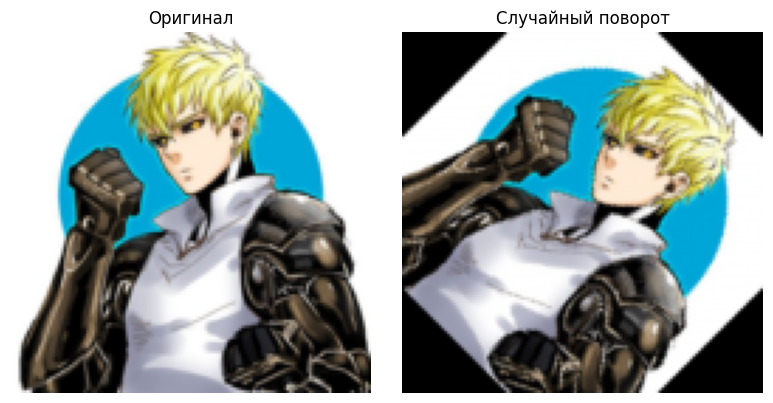

Изображение сохранено: results\task1_Генос_grayscale.png


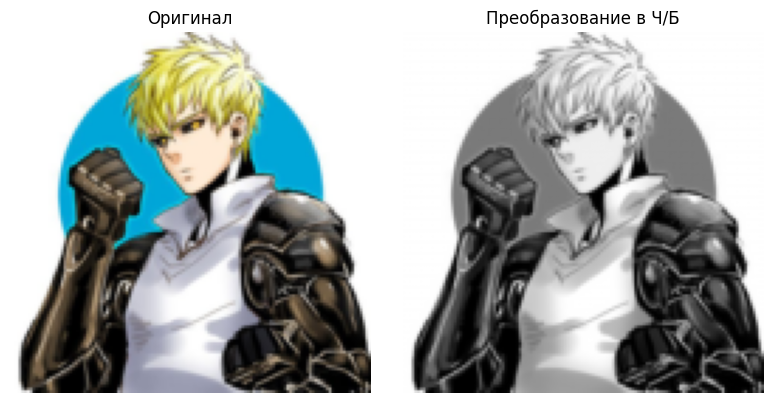

Изображение сохранено: results\task1_Генос_combo.png


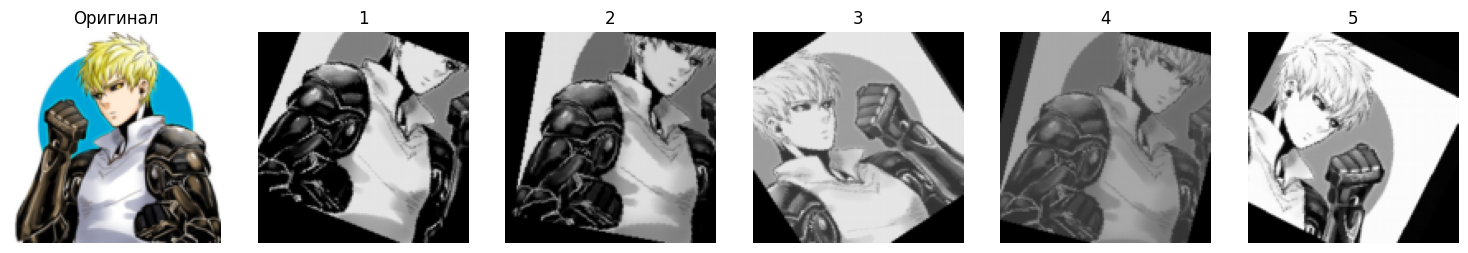


аугментация класса: Сайтама

Изображение сохранено: results\task1_Сайтама_hflip.png


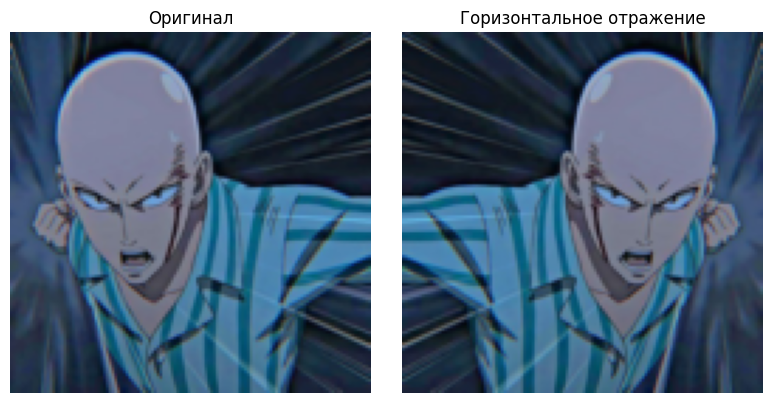

Изображение сохранено: results\task1_Сайтама_crop.png


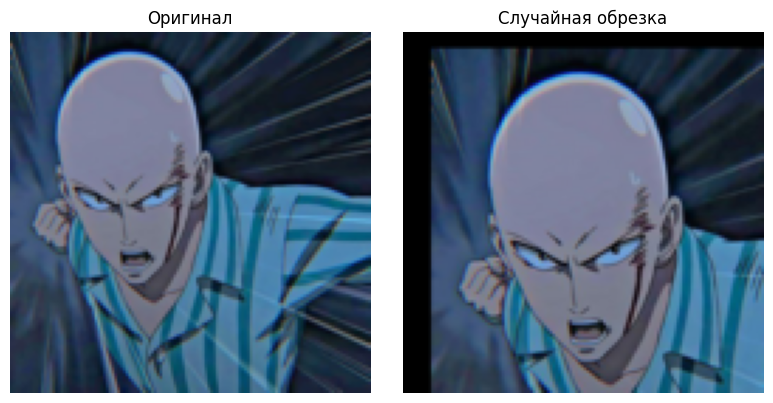

Изображение сохранено: results\task1_Сайтама_jitter.png


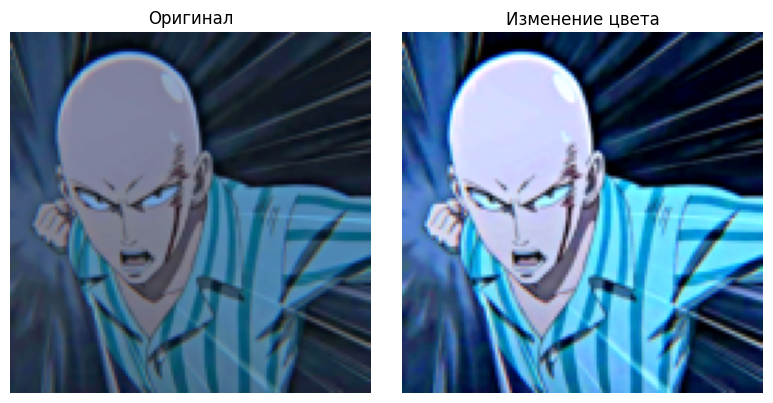

Изображение сохранено: results\task1_Сайтама_rotation.png


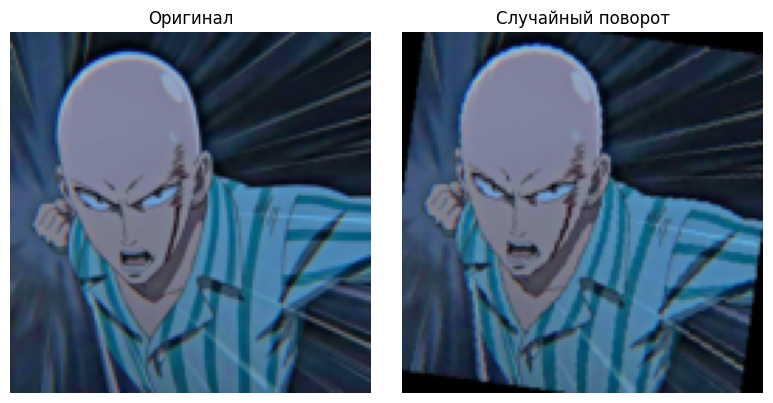

Изображение сохранено: results\task1_Сайтама_grayscale.png


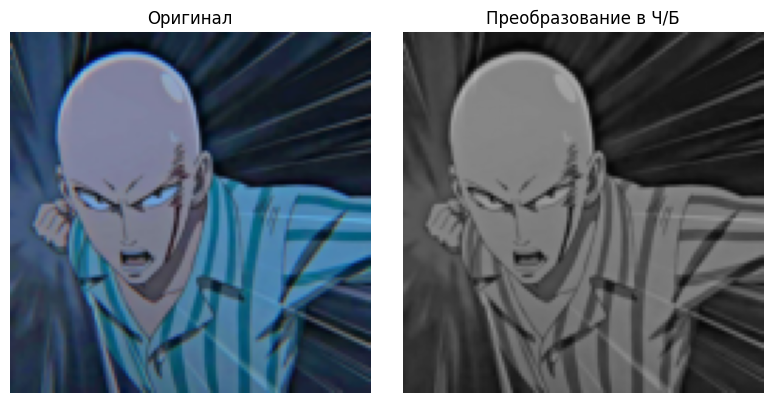

In [ ]:
full_dataset = CustomImageDataset(root_dir=DATA_ROOT_TRAIN, transform=None, target_size=(224, 224))
class_names = full_dataset.get_class_names()
print(f"Найдено {len(full_dataset)} изображений в {len(class_names)} классах.")

images_to_show = []
seen_labels = set()
for img, label in full_dataset:
    if label not in seen_labels:
        images_to_show.append((img, label))
        seen_labels.add(label)
    if len(images_to_show) >= 5:
        break

standard_augs = [
    ("Горизонтальное отражение", "hflip", transforms.RandomHorizontalFlip(p=1.0)),
    ("Случайная обрезка", "crop", transforms.RandomCrop(180, padding=20, pad_if_needed=True)),
    ("Изменение цвета", "jitter", transforms.ColorJitter(brightness=0.5, contrast=0.5)),
    ("Случайный поворот", "rotation", transforms.RandomRotation(degrees=45)),
    ("Преобразование в Ч/Б", "grayscale", transforms.RandomGrayscale(p=1.0))
]

for original_img, label in images_to_show:
    class_name = class_names[label]
    print(f"\nаугментация класса: {class_name}\n")
    
    for aug_name, aug_save_name, aug_transform in standard_augs:
        pipeline = transforms.Compose([aug_transform, transforms.ToTensor()])
        augmented_img = pipeline(original_img)
        show_single_augmentation(
            original_img, augmented_img, aug_name,
            save_name=f"task1_{class_name}_{aug_save_name}.png"
        )
    
    all_augs_pipeline = transforms.Compose([aug for _, _, aug in standard_augs] + [transforms.ToTensor()])
    combined_imgs = [all_augs_pipeline(original_img) for _ in range(5)]
    titles = [f"{i+1}" for i in range(5)]
    show_multiple_augmentations(
        original_img, combined_imgs, titles,
        save_name=f"task1_{class_name}_combo.png"
    )

In [26]:
class RandomGaussianBlur:
    """Применяет Гауссово размытие со случайным радиусом."""

    def __init__(self, p=0.5, min_radius=0.1, max_radius=2.0):
        self.p = p
        self.min_radius = min_radius
        self.max_radius = max_radius

    def __call__(self, img):
        if random.random() < self.p:
            radius = random.uniform(self.min_radius, self.max_radius)
            return img.filter(ImageFilter.GaussianBlur(radius=radius))
        return img


class RandomContrast:
    """Случайно изменяет контраст изображения."""

    def __init__(self, p=0.5, min_factor=0.5, max_factor=1.5):
        self.p = p
        self.min_factor = min_factor
        self.max_factor = max_factor

    def __call__(self, img):
        if random.random() < self.p:
            factor = random.uniform(self.min_factor, self.max_factor)
            enhancer = ImageEnhance.Contrast(img)
            return enhancer.enhance(factor)
        return img


class RandomBrightness:
    """Случайно изменяет яркость изображения."""

    def __init__(self, p=0.5, min_factor=0.5, max_factor=1.5):
        self.p = p
        self.min_factor = min_factor
        self.max_factor = max_factor

    def __call__(self, img):
        if random.random() < self.p:
            factor = random.uniform(self.min_factor, self.max_factor)
            enhancer = ImageEnhance.Brightness(img)
            return enhancer.enhance(factor)
        return img


print("Кастомные аугментации определены: RandomGaussianBlur, RandomContrast, RandomBrightness.")

Кастомные аугментации определены: RandomGaussianBlur, RandomContrast, RandomBrightness.


Изображение сохранено: images\task2_blur_vs_noise.png


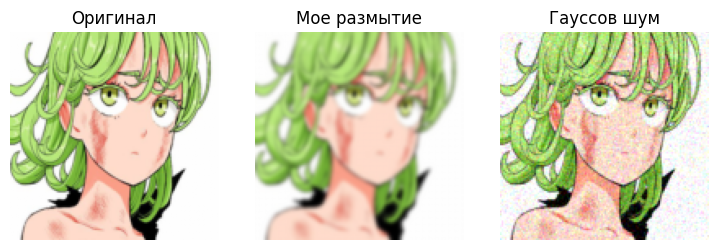

Изображение сохранено: images\task2_contrast_vs_brightness.png


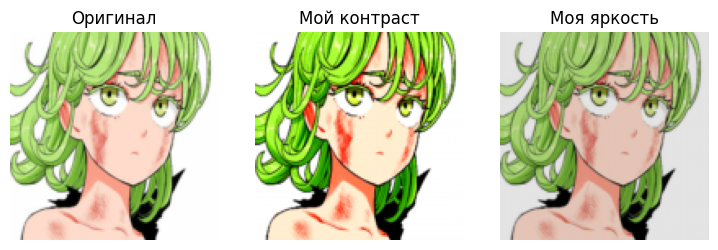

In [15]:
# 1. Сравнение добавления шума
my_blur_aug = transforms.Compose([RandomGaussianBlur(p=1.0, max_radius=3), transforms.ToTensor()])
extra_noise_aug = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(std=0.15)])
show_multiple_augmentations(
    original_img, [my_blur_aug(original_img), extra_noise_aug(original_img)],
    ["Мое размытие", "Гауссов шум"],
    save_name="task2_blur_vs_noise.png"
)

# 2. Демонстрация яркости и контраста
my_contrast_aug = transforms.Compose([RandomContrast(p=1.0, max_factor=2.0), transforms.ToTensor()])
my_brightness_aug = transforms.Compose([RandomBrightness(p=1.0, max_factor=2.0), transforms.ToTensor()])
show_multiple_augmentations(
    original_img, [my_contrast_aug(original_img), my_brightness_aug(original_img)],
    ["Мой контраст", "Моя яркость"],
    save_name="task2_contrast_vs_brightness.png")

Анализ размеров:   0%|          | 0/180 [00:00<?, ?it/s]


Всего изображений: 180
Минимальный размер: (210, 240), Максимальный размер: (736, 1308), Средний размер: (538, 623)


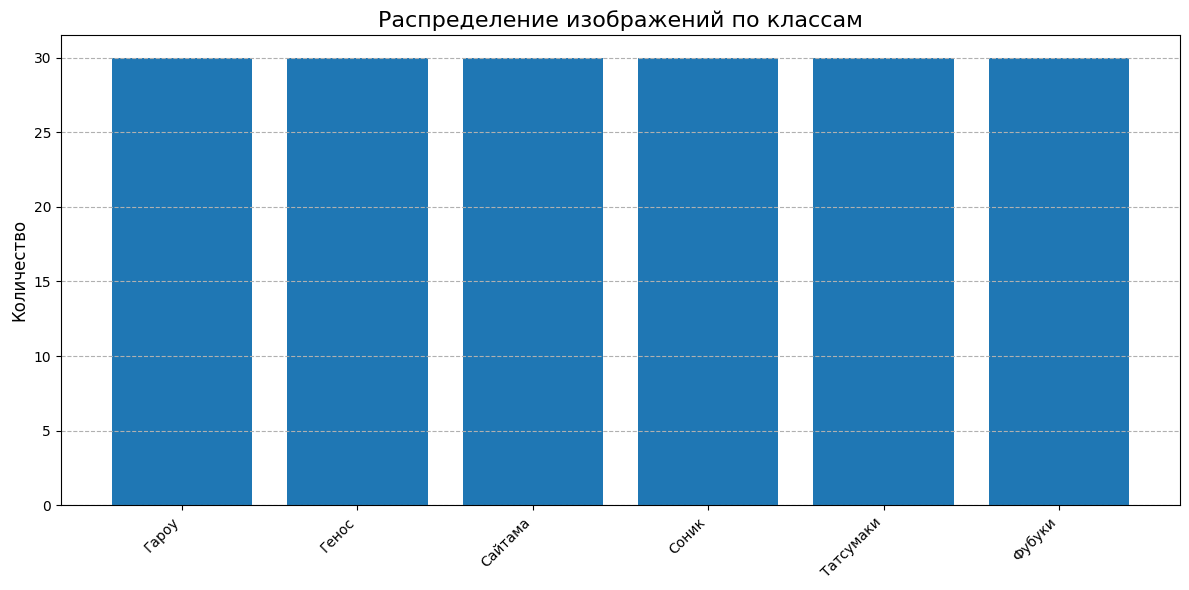

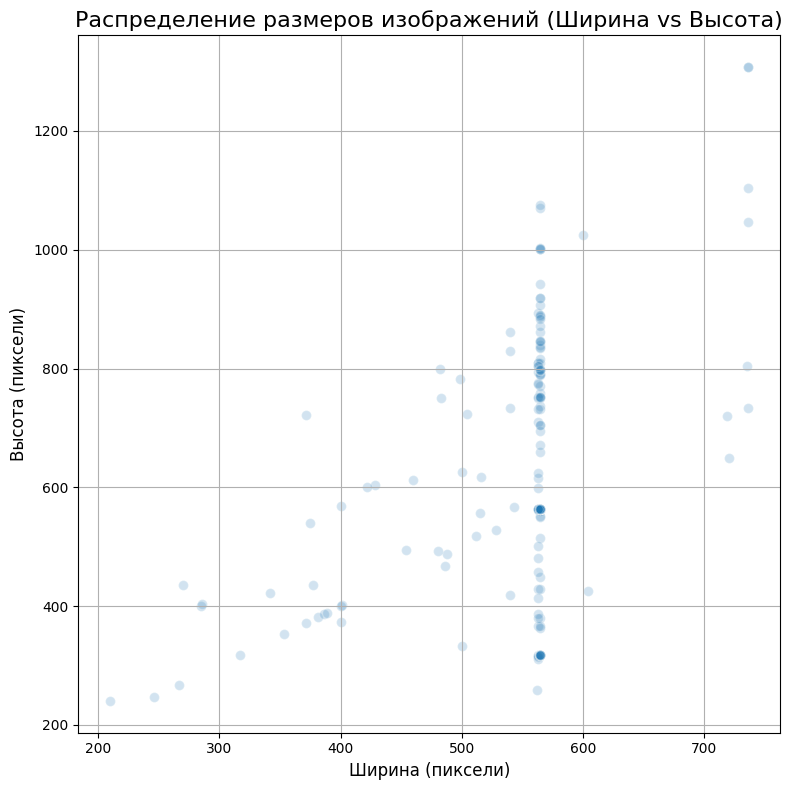

In [16]:
# Собираем информацию, не загружая изображения целиком
image_paths_analysis = full_dataset.images
labels_analysis = [full_dataset.labels[i] for i in range(len(full_dataset))]
class_names_analysis = full_dataset.get_class_names()
labels_named = [class_names_analysis[l] for l in labels_analysis]

widths, heights = [], []
for img_path in tqdm(image_paths_analysis, desc="Анализ размеров"):
    with Image.open(img_path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

# Подсчет статистики
class_counts = Counter(labels_named)
min_size, max_size = (min(widths), min(heights)), (max(widths), max(heights))
avg_size = (int(np.mean(widths)), int(np.mean(heights)))

print(f"\nВсего изображений: {len(image_paths_analysis)}")
print(f"Минимальный размер: {min_size}, Максимальный размер: {max_size}, Средний размер: {avg_size}")

# Визуализация
# Гистограмма по классам
plt.figure(figsize=(12, 6))
plt.bar(*zip(*sorted(class_counts.items())))
plt.title("Распределение изображений по классам", fontsize=16)
plt.ylabel("Количество", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "task3_распределение_по_классам.png"))
plt.show()

# Распределение размеров
plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, alpha=0.2, edgecolors='w', s=50)
plt.title("Распределение размеров изображений (Ширина vs Высота)", fontsize=16)
plt.xlabel("Ширина (пиксели)", fontsize=12)
plt.ylabel("Высота (пиксели)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "task3_размеры изображений.png"))
plt.show()

In [17]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentations = {}
        print("Пайплайн аугментаций создан.")

    def add_augmentation(self, name, aug):
        """Добавляет аугментацию в пайплайн."""
        self.augmentations[name] = aug
        print(f"Добавлена аугментация: '{name}'")

    def remove_augmentation(self, name):
        """Удаляет аугментацию из пайплайна."""
        if name in self.augmentations:
            del self.augmentations[name]
            print(f"Удалена аугментация: '{name}'")
        else:
            print(f"Аугментация '{name}' не найдена.")

    def apply(self, image):
        """Применяет все аугментации в пайплайне к изображению."""
        current_augs = list(self.augmentations.values())
        pipeline = transforms.Compose(current_augs + [transforms.ToTensor()])
        return pipeline(image)

    def get_augmentations(self):
        """Возвращает словарь текущих аугментаций."""
        return self.augmentations

    def __str__(self):
        return f"Текущие аугментации в пайплайне: {list(self.augmentations.keys())}"


Пайплайн аугментаций создан.

 Конфигурация 'Light' 
Добавлена аугментация: 'flip'
Текущие аугментации в пайплайне: ['flip']


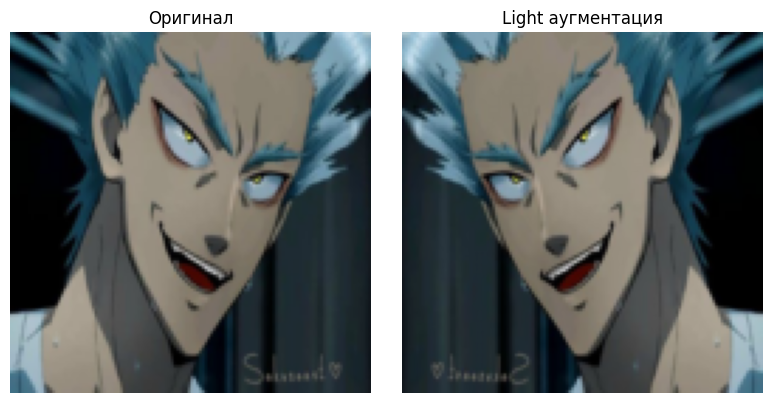


 Конфигурация 'Medium' 
Добавлена аугментация: 'jitter'
Текущие аугментации в пайплайне: ['flip', 'jitter']


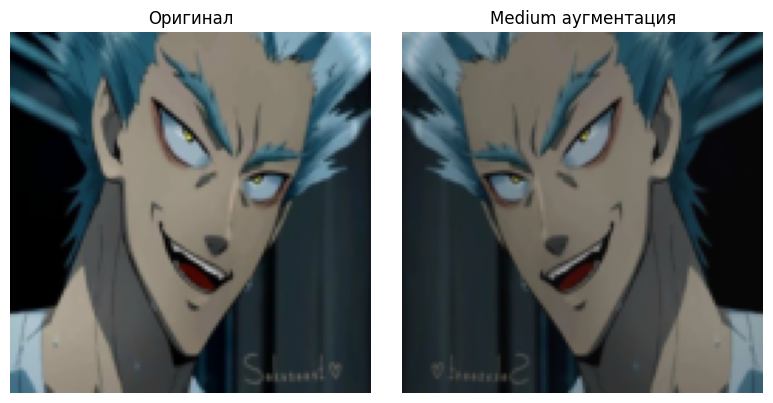


 Конфигурация 'Heavy' 
Добавлена аугментация: 'rotation'
Добавлена аугментация: 'blur'
Текущие аугментации в пайплайне: ['flip', 'jitter', 'rotation', 'blur']


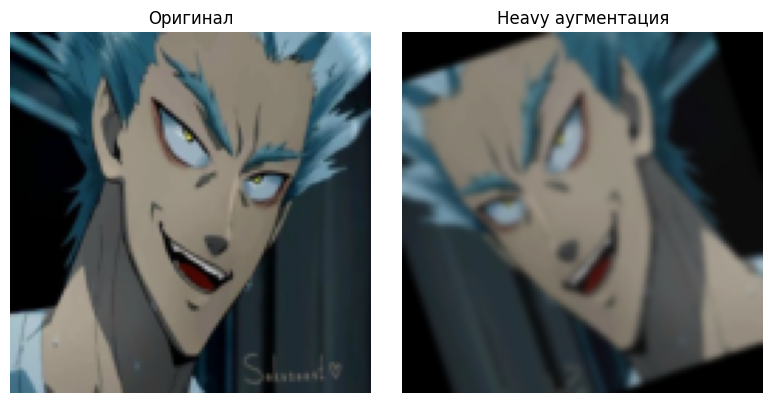


 Удаляем 'rotation' и 'blur' 
Удалена аугментация: 'rotation'
Удалена аугментация: 'blur'
Текущие аугментации в пайплайне: ['flip', 'jitter']


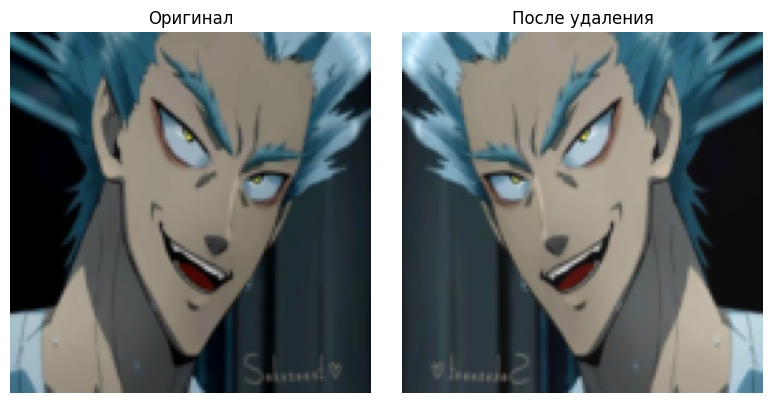

In [18]:

original_img, _ = full_dataset[15]

pipeline = AugmentationPipeline()

print("\n Конфигурация 'Light' ")
pipeline.add_augmentation("flip", transforms.RandomHorizontalFlip(p=1.0))
print(pipeline)
light_aug_img = pipeline.apply(original_img)
show_single_augmentation(original_img, light_aug_img, "Light аугментация")

print("\n Конфигурация 'Medium' ")
pipeline.add_augmentation("jitter", transforms.ColorJitter(brightness=0.3, contrast=0.3))
print(pipeline)
medium_aug_img = pipeline.apply(original_img)
show_single_augmentation(original_img, medium_aug_img, "Medium аугментация")

print("\n Конфигурация 'Heavy' ")
pipeline.add_augmentation("rotation", transforms.RandomRotation(20))
pipeline.add_augmentation("blur", RandomGaussianBlur(p=1.0))
print(pipeline)
heavy_aug_img = pipeline.apply(original_img)
show_single_augmentation(original_img, heavy_aug_img, "Heavy аугментация")

print("\n Удаляем 'rotation' и 'blur' ")
pipeline.remove_augmentation("rotation")
pipeline.remove_augmentation("blur")
print(pipeline)
final_aug_img = pipeline.apply(original_img)
show_single_augmentation(original_img, final_aug_img, "После удаления")

Эксперимент с размерами:   0%|          | 0/4 [00:00<?, ?it/s]


Результаты эксперимента:
Размер: 64x64 | Время: 0.0583 сек | Память (дельта): -100.33 MB
Размер: 128x128 | Время: 0.1696 сек | Память (дельта): 1.95 MB
Размер: 224x224 | Время: 0.4701 сек | Память (дельта): 19.22 MB
Размер: 512x512 | Время: 2.2835 сек | Память (дельта): 101.44 MB


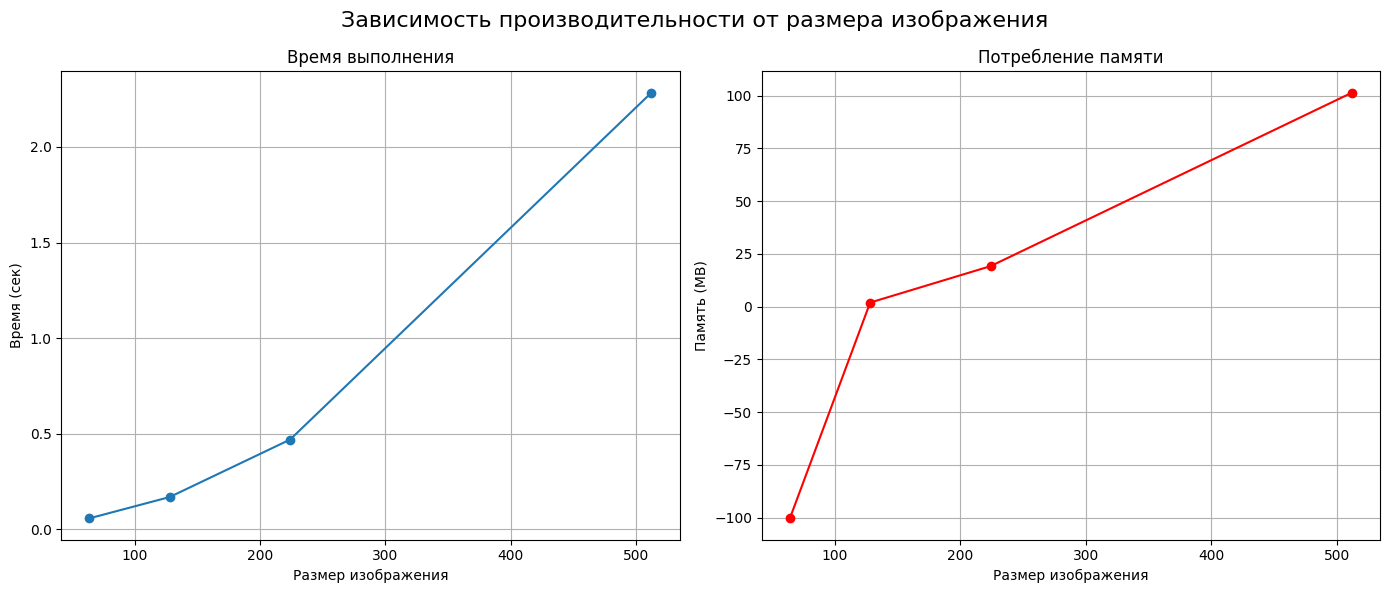

In [19]:
sizes = [64, 128, 224, 512]
num_images_to_test = 100
results = {"size": [], "time": [], "memory_mb": []}

heavy_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    RandomGaussianBlur(p=0.5),
    transforms.ToTensor(),
    CutOut(p=0.5)
])

process = psutil.Process(os.getpid())

for size in tqdm(sizes, desc="Эксперимент с размерами"):
    mem_before = process.memory_info().rss / (1024 * 1024)

    temp_dataset = CustomImageDataset(root_dir=DATA_ROOT_TRAIN, transform=None, target_size=(size, size))
    images_for_test = [temp_dataset[i][0] for i in range(num_images_to_test)]

    start_time = time.time()
    for img in images_for_test:
        _ = heavy_pipeline(img)
    end_time = time.time()

    mem_after = process.memory_info().rss / (1024 * 1024)

    results["size"].append(size)
    results["time"].append(end_time - start_time)
    results["memory_mb"].append(mem_after - mem_before)

print("\nРезультаты эксперимента:")
for s, t, m in zip(results['size'], results['time'], results['memory_mb']):
    print(f"Размер: {s}x{s} | Время: {t:.4f} сек | Память (дельта): {m:.2f} MB")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Зависимость производительности от размера изображения", fontsize=16)

ax1.plot(results['size'], results['time'], 'o-')
ax1.set_title("Время выполнения")
ax1.set_xlabel("Размер изображения")
ax1.set_ylabel("Время (сек)")
ax1.grid(True)

ax2.plot(results['size'], results['memory_mb'], 'o-r')
ax2.set_title("Потребление памяти")
ax2.set_xlabel("Размер изображения")
ax2.set_ylabel("Память (MB)")
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "Производительность_от_размера.png"))
plt.show()

In [20]:


#  1. Подготовка данных 

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ]),
}

train_dataset = CustomImageDataset(DATA_ROOT_TRAIN, transform=data_transforms['train'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

num_classes = len(train_dataset.get_class_names())
print(f"Количество классов: {num_classes}")

#  2. Загрузка и модификация модели 
model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#  3. Цикл обучения и валидации 
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 10
history = {'train_loss': [], 'train_acc': []}

for epoch in range(num_epochs):
    print(f"\nЭпоха {epoch + 1}/{num_epochs}")
    
    # Фаза обучения
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in tqdm(train_loader, desc="Обучение"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc.item())
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")



Количество классов: 6

Эпоха 1/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.9467 Acc: 0.1444

Эпоха 2/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.7790 Acc: 0.2278

Эпоха 3/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.6991 Acc: 0.2778

Эпоха 4/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.5933 Acc: 0.3444

Эпоха 5/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.5279 Acc: 0.4389

Эпоха 6/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.4397 Acc: 0.5167

Эпоха 7/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.3543 Acc: 0.5444

Эпоха 8/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.2637 Acc: 0.6222

Эпоха 9/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.1996 Acc: 0.6500

Эпоха 10/10


Обучение:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 1.1936 Acc: 0.6389


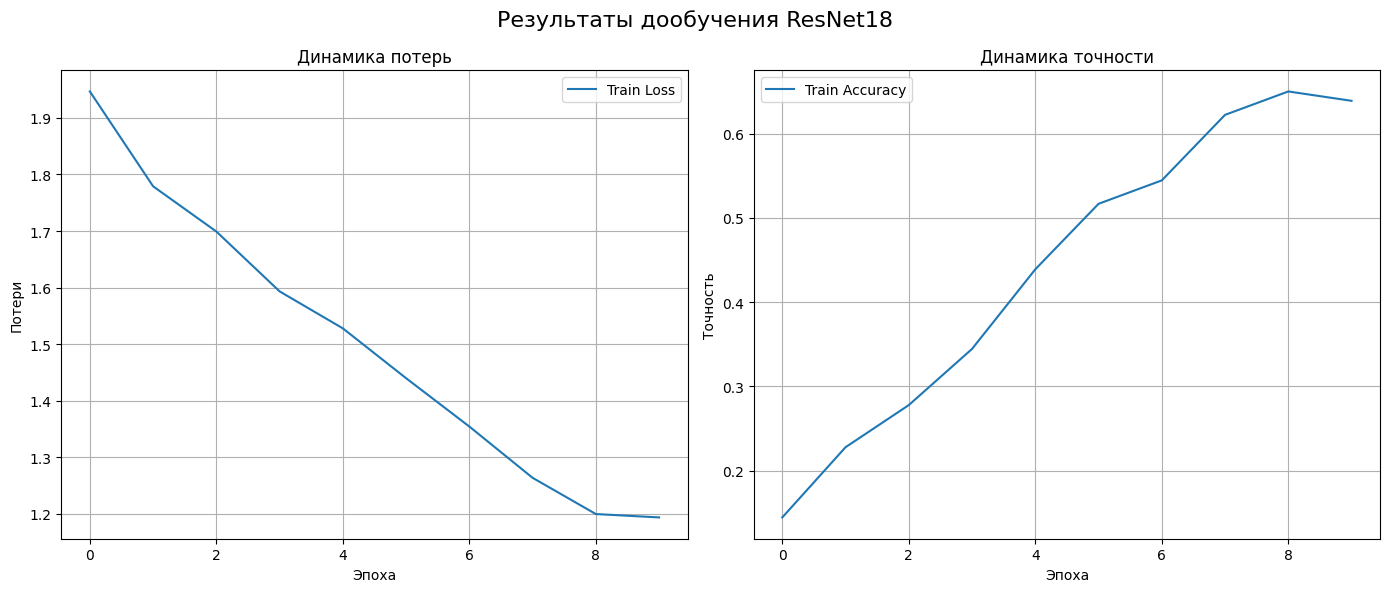

In [21]:
train_acc_plot = [acc for acc in history['train_acc']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Результаты дообучения ResNet18", fontsize=16)

# График потерь
ax1.plot(history['train_loss'], label='Train Loss')
ax1.set_title("Динамика потерь"); ax1.set_xlabel("Эпоха"); ax1.set_ylabel("Потери"); ax1.legend(); ax1.grid(True)

# График точности
ax2.plot(train_acc_plot, label='Train Accuracy')
ax2.set_title("Динамика точности"); ax2.set_xlabel("Эпоха"); ax2.set_ylabel("Точность"); ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "Результаты_дообучения.png"))
plt.show()